In [3]:
import os
import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
from osgeo import gdal
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
ds = gdal.Open('/content/drive/MyDrive/Projects/GUI/training.tif')

# Reading each band
for i in range(1,5):
  exec(f'Band_{i+1} = ds.GetRasterBand({i}).ReadAsArray()')

# Creating a FCC
RGB = np.dstack((Band_2,Band_3,Band_4))

##**Image Statistics**

In [5]:
image_stat = {'Bands': ['Green','Red','NIR','SWIR'],
              'Mean': list(map(np.mean,(Band_2, Band_3, Band_4, Band_5))),
              'Standard Deviation': list(map(np.std,(Band_2, Band_3, Band_4, Band_5))),
              'Variance': list(map(np.var,(Band_2, Band_3, Band_4, Band_5)))}

pd.DataFrame(image_stat)

,Bands,Mean,Standard Deviation,Variance
0,Green,142.009155,22.387142,501.184174
1,Red,127.100700,27.137877,736.464355
2,NIR,201.453522,39.202526,1536.838135
3,SWIR,197.956116,57.210777,3273.072998


In [6]:
# Calculating Covariance (using centered data) and Correlation Matrix
array = np.vstack((Band_2.ravel(),Band_3.ravel(),Band_4.ravel(),Band_5.ravel()))
centered_array = array - np.mean(array, axis=1, keepdims=True)
covariance = np.cov(centered_array)
correlation = np.corrcoef(centered_array)

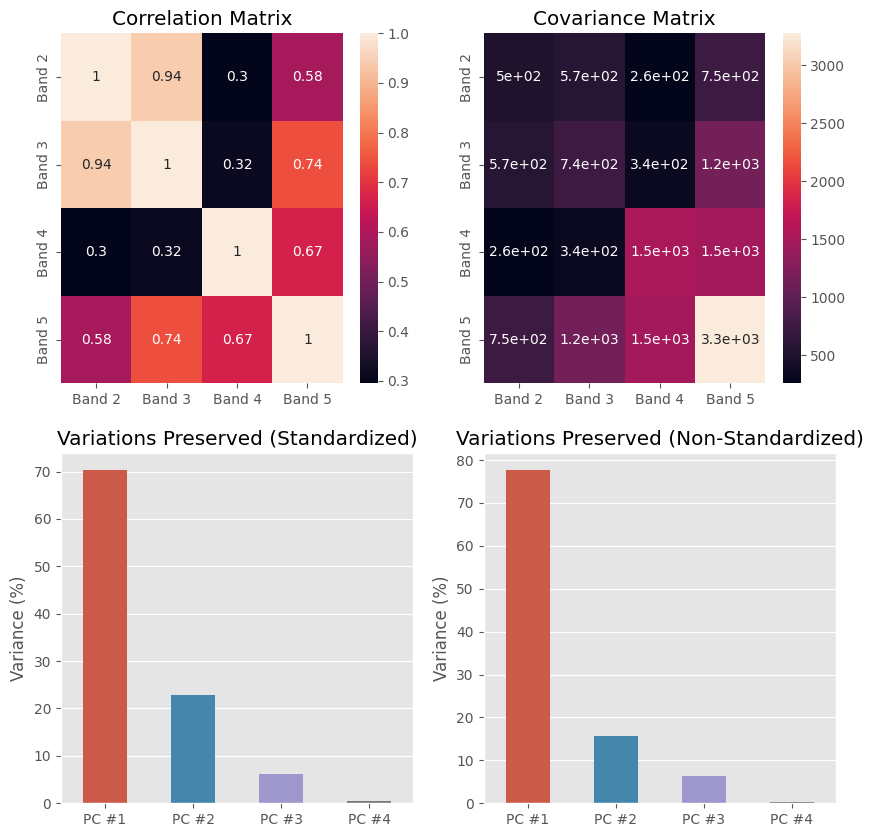

In [7]:
# Calculating and Sorting Eigen Values and Eigen Vectors
def eig(matrix):
  Eigen_values, Eigen_vectors = np.linalg.eig(matrix)
  order = Eigen_values.argsort()[::-1]
  Eigen_values = Eigen_values[order]
  Eigen_vectors = Eigen_vectors[:,order]
  return Eigen_values,Eigen_vectors

Eigen_values_s,Eigen_vectors_s = eig(correlation)
Eigen_values_ns,Eigen_vectors_ns = eig(covariance)
# Variance Preserved
Variance_s = [Eigen_values_s[i]/np.sum(Eigen_values_s)*100 for i in range(4)]
Variance_ns = [Eigen_values_ns[i]/np.sum(Eigen_values_ns)*100 for i in range(4)]


plt.subplots(figsize=[10,10])
plt.style.use('ggplot')
plt.subplot(221),sns.heatmap(correlation,annot=True,xticklabels=['Band 2','Band 3','Band 4','Band 5'],yticklabels=['Band 2','Band 3','Band 4','Band 5']),plt.title('Correlation Matrix')
plt.subplot(222),sns.heatmap(covariance,annot=True,xticklabels=['Band 2','Band 3','Band 4','Band 5'],yticklabels=['Band 2','Band 3','Band 4','Band 5']),plt.title('Covariance Matrix')
plt.subplot(223),sns.barplot(x=['PC #1', 'PC #2', 'PC #3', 'PC #4'], y=Variance_s,width=0.5),plt.ylabel('Variance (%)'),plt.title('Variations Preserved (Standardized)')
plt.subplot(224),sns.barplot(x=['PC #1', 'PC #2', 'PC #3', 'PC #4'], y=Variance_ns,width=0.5),plt.ylabel('Variance (%)'),plt.title('Variations Preserved (Non-Standardized)')
plt.show()

##**Factor Loadings**

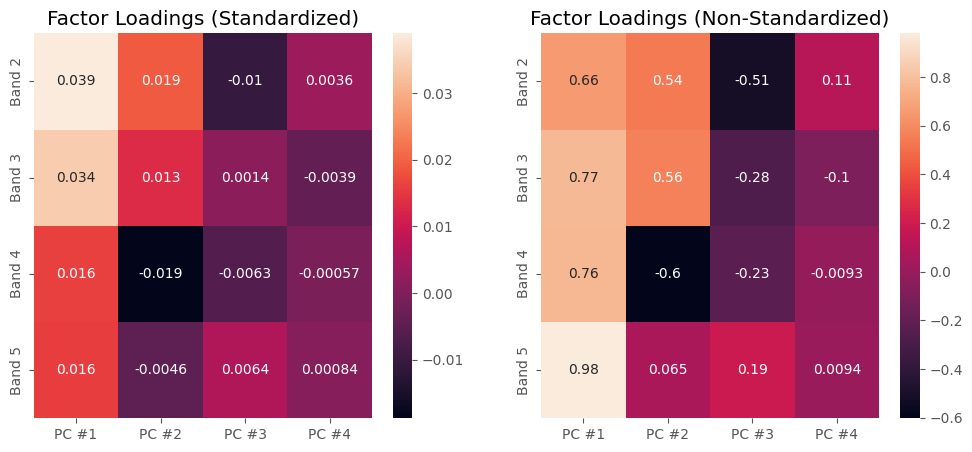

In [8]:
def fact_load(Eigen_values,Eigen_vectors):
  fact = np.zeros((4,4))
  for i in range(4):
      for j in range(4):
          fact[i,j] = (Eigen_vectors[i,j] * np.sqrt(Eigen_values[j]))/np.sqrt(image_stat.get('Variance')[i])
  return fact


plt.subplots(figsize=[12,5])
plt.style.use('ggplot')
plt.subplot(121),sns.heatmap(fact_load(Eigen_values_s,Eigen_vectors_s),annot=True,xticklabels=['PC #1', 'PC #2', 'PC #3', 'PC #4'],yticklabels=['Band 2','Band 3','Band 4','Band 5']),plt.title('Factor Loadings (Standardized)')
plt.subplot(122),sns.heatmap(fact_load(Eigen_values_ns,Eigen_vectors_ns),annot=True,xticklabels=['PC #1', 'PC #2', 'PC #3', 'PC #4'],yticklabels=['Band 2','Band 3','Band 4','Band 5']),plt.title('Factor Loadings (Non-Standardized)')
plt.show()

##**PCA Results**

Standardized

In [9]:
image_stat.update({'Eigen Values':Eigen_values_s,
                   'Percentage Contribution': Variance_s,
                   'Cumulative Contribution': np.cumsum(Variance_s)})

pd.DataFrame(image_stat)

,Bands,Mean,Standard Deviation,Variance,Eigen Values,Percentage Contribution,Cumulative Contribution
0,Green,142.009155,22.387142,501.184174,2.813570,70.339253,70.339253
1,Red,127.100700,27.137877,736.464355,0.916701,22.917520,93.256773
2,NIR,201.453522,39.202526,1536.838135,0.248918,6.222950,99.479722
3,SWIR,197.956116,57.210777,3273.072998,0.020811,0.520278,100.000000


Non-Standardized

In [10]:
image_stat.update({'Eigen Values':Eigen_values_ns,
                   'Percentage Contribution': Variance_ns,
                   'Cumulative Contribution': np.cumsum(Variance_ns)})

pd.DataFrame(image_stat)

,Bands,Mean,Standard Deviation,Variance,Eigen Values,Percentage Contribution,Cumulative Contribution
0,Green,142.009155,22.387142,501.184174,4697.947410,77.683297,77.683297
1,Red,127.100700,27.137877,736.464355,950.687006,15.720164,93.403461
2,NIR,201.453522,39.202526,1536.838135,384.483958,6.357666,99.761127
3,SWIR,197.956116,57.210777,3273.072998,14.445985,0.238873,100.000000


##**Comparison**

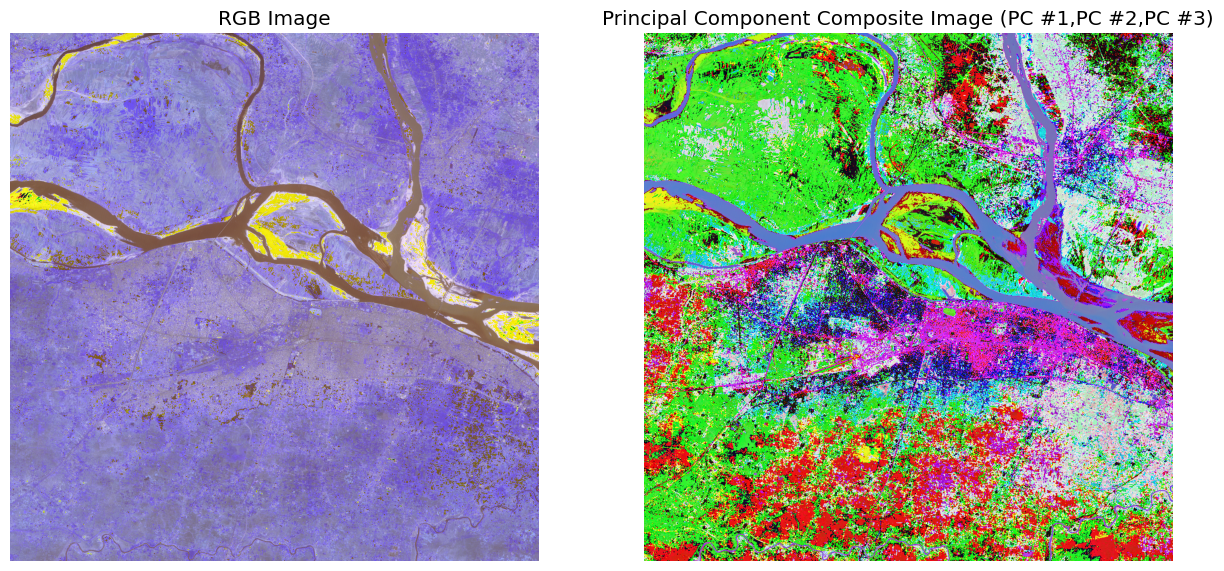

In [11]:
# Transformed data
pca_data = centered_array.T @ Eigen_vectors_s

# De-stacking data and reshaping to obtain principal component uncorrelated image data
for i in range(4):
  exec(f'new_band_{i+2} = pca_data.T[{i}].reshape((RGB.shape[:2]))')

transformed = np.dstack((new_band_2,new_band_3,new_band_4)).astype(np.uint8)
original = np.dstack((Band_2,Band_3,Band_4)).astype(np.uint8)

plt.subplots(figsize=[15,15])
plt.subplot(121).imshow(original),plt.axis('off'),plt.title('RGB Image')
plt.subplot(122).imshow(transformed),plt.axis('off'),plt.title('Principal Component Composite Image (PC #1,PC #2,PC #3)')
plt.show()

##**Loss of information**

<Figure size 640x480 with 0 Axes>

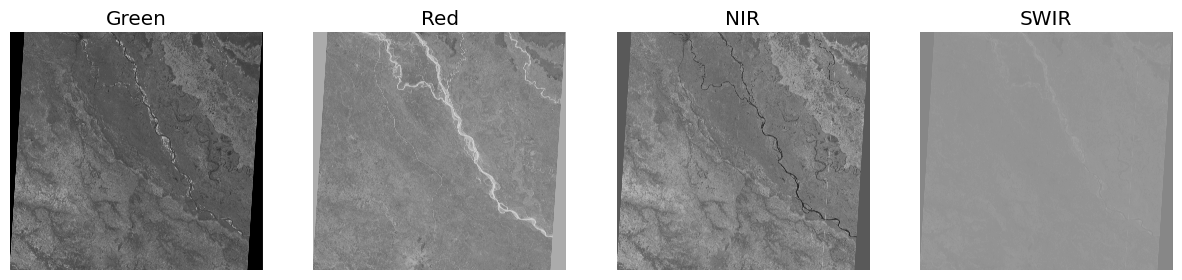

In [ ]:
plt.gray()
plt.subplots(figsize=[15,15])
bands = [new_band_2, new_band_3, new_band_4, new_band_5]
Band_names = ['Green','Red','NIR','SWIR']
for i, band in enumerate(bands):
    plt.subplot(1, 4, i+1)
    plt.title(Band_names[i])
    plt.imshow(band)
    plt.axis('off')
plt.show()